In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import datetime
from cartopy.feature.nightshade import Nightshade
import matplotlib.colors as mcolors

ERROR 1: PROJ: proj_create_from_database: Open of /home/debasish/anacondainstaller/ENTER/envs/py310/share/proj failed


In [4]:
inastfilepath = r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0315_L1B_STD_V01R00.h5'
insatfile = h5py.File(inastfilepath, 'r')

In [8]:

def count2bt(count,lut):
    bt = lut[count]
    return bt

viscount = np.array(insatfile['IMG_VIS'])[0,:,:]
vislut = np.array(insatfile['IMG_VIS_ALBEDO'])
visfill = insatfile['IMG_VIS'].attrs['_FillValue'][0]
albedoarray = count2bt(viscount,vislut)
albedoarray[viscount == visfill] = np.nan


swircount = np.array(insatfile['IMG_SWIR'])[0,:,:]
swirlut = np.array(insatfile['IMG_SWIR_RADIANCE'])
swirfill = insatfile['IMG_SWIR'].attrs['_FillValue'][0]
swirradarray = count2bt(swircount,swirlut)
swirradarray[swircount == swirfill] = np.nan

tir1count = np.array(insatfile['IMG_TIR1'])[0,:,:]
fillvalue = insatfile['IMG_TIR1'].attrs['_FillValue'][0]
tir1lut = np.array(insatfile['IMG_TIR1_TEMP'])
tir1bt = count2bt(tir1count,tir1lut)
tir1bt[tir1count == fillvalue] = np.nan

tir2count = np.array(insatfile['IMG_TIR2'])[0,:,:]
fillvalue = insatfile['IMG_TIR2'].attrs['_FillValue'][0]
tir2lut = np.array(insatfile['IMG_TIR2_TEMP'])
tir2bt = count2bt(tir2count,tir2lut)
tir2bt[tir2count == fillvalue] = np.nan

mircount = np.array(insatfile['IMG_MIR'])[0,:,:]
fillvalue = insatfile['IMG_MIR'].attrs['_FillValue'][0]
mirlut = np.array(insatfile['IMG_MIR_TEMP'])
mirbt = count2bt(mircount,mirlut)
mirbt[mircount == fillvalue] = np.nan


longitudearray = np.array(insatfile['Longitude'])/100
latitudearray = np.array(insatfile['Latitude'])/100
fillvalue = insatfile['Longitude'].attrs['_FillValue'][0]/100
latitudearray[latitudearray == fillvalue] = np.nan
longitudearray[longitudearray == fillvalue] = np.nan
sat_elevation = np.array(insatfile['Sat_Elevation'])/100
sat_elevation[sat_elevation == 32767/100] = np.nan

insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
print(insatdate)
insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
print(insattime)
acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
print(acqstart)
acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]
print(acqend)


01JAN2019
0315
03:15:22
03:42:16


In [9]:
albedodownsized = albedoarray[::4,::4]
swirraddownsized = swirradarray[::4,::4]
print(albedodownsized.shape,swirraddownsized.shape)

(2816, 2805) (2816, 2805)


In [17]:
dffullfile = pd.DataFrame({
                           'albedo':albedodownsized.flatten(),
                           'swirrad':swirraddownsized.flatten(),
                           'btmir':mirbt.flatten(),
                           'bttir1':tir1bt.flatten(),
                           'bttir2':tir2bt.flatten(),
                           'insatcorvislat':latitudearray.flatten(),
                           'insatcorvislon':longitudearray.flatten(),
                           'satelevation':sat_elevation.flatten(),
                     })

#Drop nan values for satelevation, btmir, bttir1, bttir2

dffullfile = dffullfile.dropna(subset=['satelevation','btmir','bttir1','bttir2', 'insatcorvislat', 'insatcorvislon'])

dffullfile.isna().sum()

albedo            1228
swirrad           1246
btmir                0
bttir1               0
bttir2               0
insatcorvislat       0
insatcorvislon       0
satelevation         0
dtype: int64

In [18]:
modeladress = r"/data/debasish/cloudetectionmodels/cloudthicknessmodel/xgboostallfeatures910mrmse/xgboostcloudthicknessallfeature910merror.pkl"
scaleradress = r"/data/debasish/cloudetectionmodels/cloudthicknessmodel/xgboostallfeatures910mrmse/trainscaler.pkl"

with open(modeladress, 'rb') as file:
    model = pickle.load(file)

with open(scaleradress, 'rb') as file:
    scaler = pickle.load(file)

dfscaled = scaler.transform(dffullfile[['albedo','swirrad','btmir','bttir1','bttir2','insatcorvislat','satelevation']])

dffullfile['thicknesspred'] = model.predict(dfscaled)

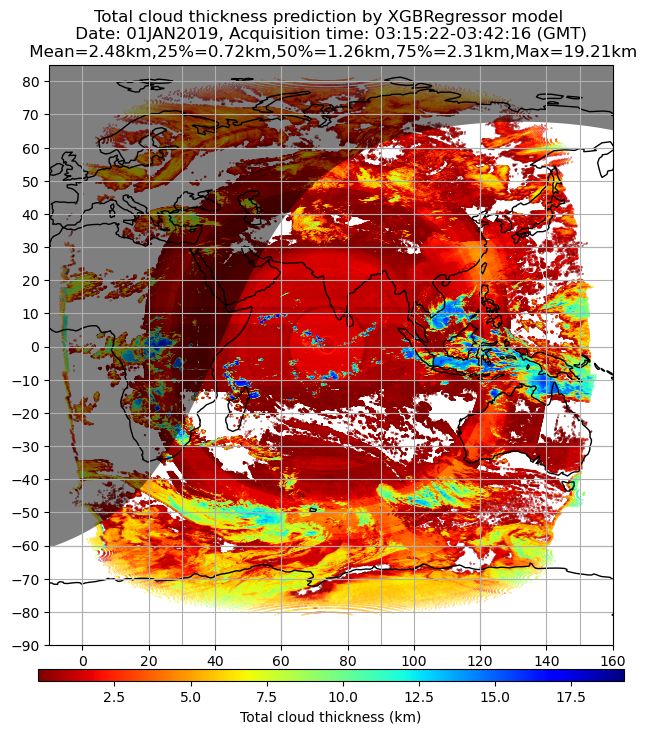

In [27]:
dffullfile = dffullfile[dffullfile['thicknesspred'] >= 0]
extent = -1
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = ccrs.PlateCarree())

plot = plt.scatter(
                dffullfile['insatcorvislon'].values[0:extent],
                dffullfile['insatcorvislat'].values[0:extent],
                c=dffullfile['thicknesspred'][0:extent],
                cmap = 'jet_r',
                s=0.05,
                transform=ccrs.PlateCarree()
                )

ax.set_global()
ax.coastlines()
ax.gridlines()

#Make longitude and latitude tick labels
ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
#Rotate xtixk labels using single line
#plt.xticks(rotation = 90)
ax.set_extent([-10,160,-85,85], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
plt.grid(True)

cbar= plt.colorbar(plot,orientation='horizontal',pad=0.039, fraction=0.019, aspect=50)
cbar.set_label('Total cloud thickness (km)')

insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
#print(insatdate)
insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
#print(insattime)
acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
#print(acqstart)
acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]
#print(acqend)
year  = int(insatdate[-4:])
month_abbreviation = insatdate[2:5]
month_number = datetime.datetime.strptime(month_abbreviation, '%b').month
day   = int(insatdate[0:2])
hour  = int(insattime[:2])
minute = int(insattime[2:4])

date = datetime.datetime(year,month_number,day,hour,minute,second=0)

date = datetime.datetime(year,month_number,day,hour,minute,second=0)

ax.add_feature(Nightshade(date, alpha=0.5))
plt.title('Total cloud thickness prediction by {} model \n Date: {}, Acquisition time: {}-{} (GMT) \n Mean={:.2f}km,25%={:.2f}km,50%={:.2f}km,75%={:.2f}km,Max={:.2f}km'.format(type(model).__name__,insatdate,acqstart,acqend,
                                                                                                                                                                                                                    dffullfile['thicknesspred'].mean(),
                                                                                                                                                                                                                    dffullfile['thicknesspred'].quantile(0.25),
                                                                                                                                                                                                                    dffullfile['thicknesspred'].quantile(0.5),
                                                                                                                                                                                                                    dffullfile['thicknesspred'].quantile(0.75),
                                                                                                                                                                                                                    dffullfile['thicknesspred'].max()))
plt.show()


In [29]:
def cloudthicknessplotter(insatfilepath,extent=-1):
    assert os.path.exists(insatfilepath), "File does not exist"
    insatfile = h5py.File(insatfilepath,'r')

    def count2bt(count,lut):
        bt = lut[count]
        return bt

    viscount = np.array(insatfile['IMG_VIS'])[0,:,:]
    vislut = np.array(insatfile['IMG_VIS_ALBEDO'])
    visfill = insatfile['IMG_VIS'].attrs['_FillValue'][0]
    albedoarray = count2bt(viscount,vislut)
    albedoarray[viscount == visfill] = np.nan


    swircount = np.array(insatfile['IMG_SWIR'])[0,:,:]
    swirlut = np.array(insatfile['IMG_SWIR_RADIANCE'])
    swirfill = insatfile['IMG_SWIR'].attrs['_FillValue'][0]
    swirradarray = count2bt(swircount,swirlut)
    swirradarray[swircount == swirfill] = np.nan

    tir1count = np.array(insatfile['IMG_TIR1'])[0,:,:]
    fillvalue = insatfile['IMG_TIR1'].attrs['_FillValue'][0]
    tir1lut = np.array(insatfile['IMG_TIR1_TEMP'])
    tir1bt = count2bt(tir1count,tir1lut)
    tir1bt[tir1count == fillvalue] = np.nan

    tir2count = np.array(insatfile['IMG_TIR2'])[0,:,:]
    fillvalue = insatfile['IMG_TIR2'].attrs['_FillValue'][0]
    tir2lut = np.array(insatfile['IMG_TIR2_TEMP'])
    tir2bt = count2bt(tir2count,tir2lut)
    tir2bt[tir2count == fillvalue] = np.nan

    mircount = np.array(insatfile['IMG_MIR'])[0,:,:]
    fillvalue = insatfile['IMG_MIR'].attrs['_FillValue'][0]
    mirlut = np.array(insatfile['IMG_MIR_TEMP'])
    mirbt = count2bt(mircount,mirlut)
    mirbt[mircount == fillvalue] = np.nan


    longitudearray = np.array(insatfile['Longitude'])/100
    latitudearray = np.array(insatfile['Latitude'])/100
    fillvalue = insatfile['Longitude'].attrs['_FillValue'][0]/100
    latitudearray[latitudearray == fillvalue] = np.nan
    longitudearray[longitudearray == fillvalue] = np.nan
    sat_elevation = np.array(insatfile['Sat_Elevation'])/100
    sat_elevation[sat_elevation == 32767/100] = np.nan

    insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
    print(insatdate)
    insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
    print(insattime)
    acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
    print(acqstart)
    acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]
    print(acqend)

    albedodownsized = albedoarray[::4,::4]
    swirraddownsized = swirradarray[::4,::4]


    dffullfile = pd.DataFrame({
                            'albedo':albedodownsized.flatten(),
                            'swirrad':swirraddownsized.flatten(),
                            'btmir':mirbt.flatten(),
                            'bttir1':tir1bt.flatten(),
                            'bttir2':tir2bt.flatten(),
                            'insatcorvislat':latitudearray.flatten(),
                            'insatcorvislon':longitudearray.flatten(),
                            'satelevation':sat_elevation.flatten(),
                        })

    #Drop nan values for satelevation, btmir, bttir1, bttir2

    dffullfile = dffullfile.dropna(subset=['satelevation','btmir','bttir1','bttir2', 'insatcorvislat', 'insatcorvislon'])


    modeladress = r"/data/debasish/cloudetectionmodels/cloudthicknessmodel/xgboostallfeatures910mrmse/xgboostcloudthicknessallfeature910merror.pkl"
    scaleradress = r"/data/debasish/cloudetectionmodels/cloudthicknessmodel/xgboostallfeatures910mrmse/trainscaler.pkl"

    with open(modeladress, 'rb') as file:
        model = pickle.load(file)

    with open(scaleradress, 'rb') as file:
        scaler = pickle.load(file)

    dfscaled = scaler.transform(dffullfile[['albedo','swirrad','btmir','bttir1','bttir2','insatcorvislat','satelevation']])

    dffullfile['thicknesspred'] = model.predict(dfscaled)

    dffullfile = dffullfile[dffullfile['thicknesspred'] >= 0]
    extent = extent


    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection = ccrs.PlateCarree())

    plot = plt.scatter(
                    dffullfile['insatcorvislon'].values[0:extent],
                    dffullfile['insatcorvislat'].values[0:extent],
                    c=dffullfile['thicknesspred'][0:extent],
                    cmap = 'jet_r',
                    s=0.05,
                    transform=ccrs.PlateCarree()
                    )

    ax.set_global()
    ax.coastlines()
    ax.gridlines()

    #Make longitude and latitude tick labels
    ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
    #Rotate xtixk labels using single line
    #plt.xticks(rotation = 90)
    ax.set_extent([-10,160,-85,85], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
    plt.grid(True)

    cbar= plt.colorbar(plot,orientation='horizontal',pad=0.039, fraction=0.019, aspect=50)
    cbar.set_label('Total cloud thickness (km)')

    insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
    #print(insatdate)
    insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
    #print(insattime)
    acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
    #print(acqstart)
    acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]
    #print(acqend)
    year  = int(insatdate[-4:])
    month_abbreviation = insatdate[2:5]
    month_number = datetime.datetime.strptime(month_abbreviation, '%b').month
    day   = int(insatdate[0:2])
    hour  = int(insattime[:2])
    minute = int(insattime[2:4])

    date = datetime.datetime(year,month_number,day,hour,minute,second=0)

    date = datetime.datetime(year,month_number,day,hour,minute,second=0)

    ax.add_feature(Nightshade(date, alpha=0.5))
    plt.title('Total cloud thickness prediction by {} model \n Date: {}, Acquisition time: {}-{} (GMT) \n Mean={:.2f}km,25%={:.2f}km,50%={:.2f}km,75%={:.2f}km,Max={:.2f}km'.format(type(model).__name__,insatdate,acqstart,acqend,
                                                                                                                                                                                                                        dffullfile['thicknesspred'].mean(),
                                                                                                                                                                                                                        dffullfile['thicknesspred'].quantile(0.25),
                                                                                                                                                                                                                        dffullfile['thicknesspred'].quantile(0.5),
                                                                                                                                                                                                                        dffullfile['thicknesspred'].quantile(0.75),
                                                                                                                                                                                                                        dffullfile['thicknesspred'].max()))
    plt.show()


01JAN2019
0315
03:15:22
03:42:16


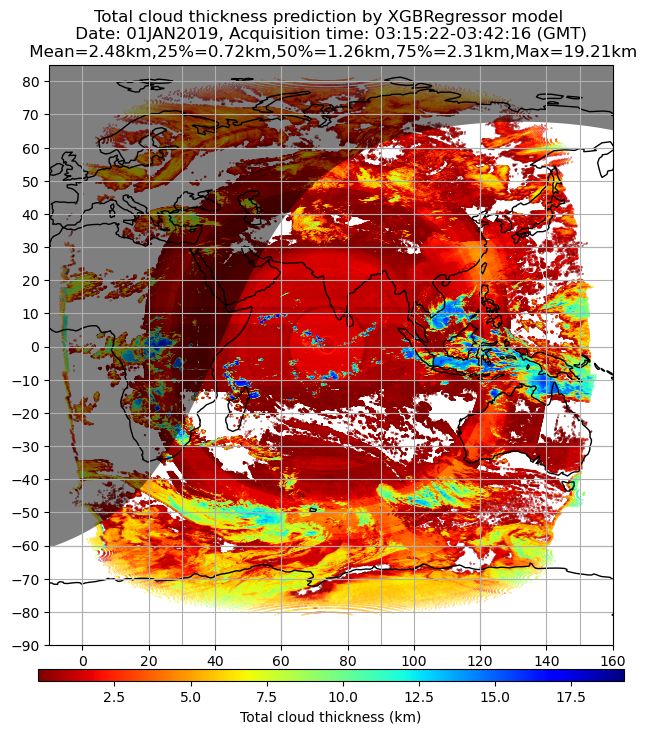

In [31]:
cloudthicknessplotter(insatfilepath = r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0315_L1B_STD_V01R00.h5')


01APR2019
0315
03:15:26
03:42:20


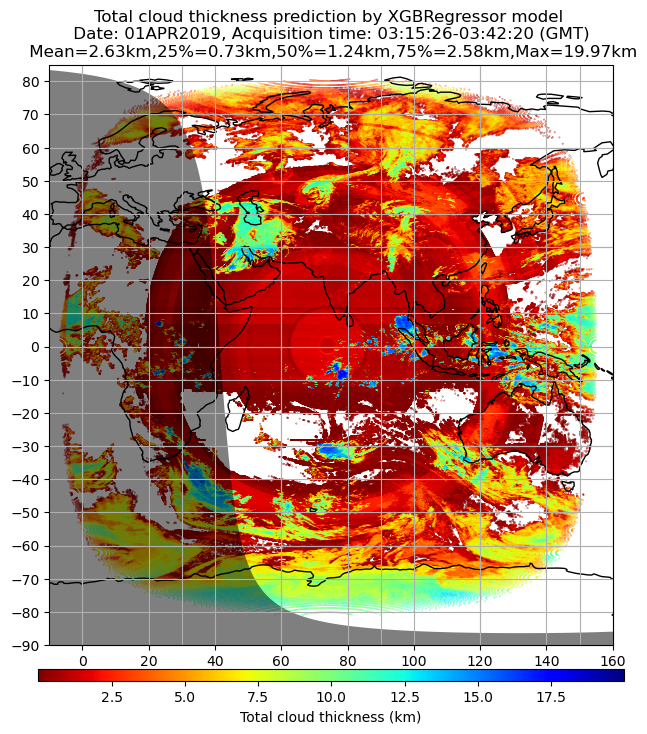

In [32]:
cloudthicknessplotter(insatfilepath = r'/data/debasish/insatdata/l1b/2019/apr2019_day1_std/3RIMG_01APR2019_0315_L1B_STD_V01R00.h5')


01AUG2019
0315
03:15:18
03:42:12


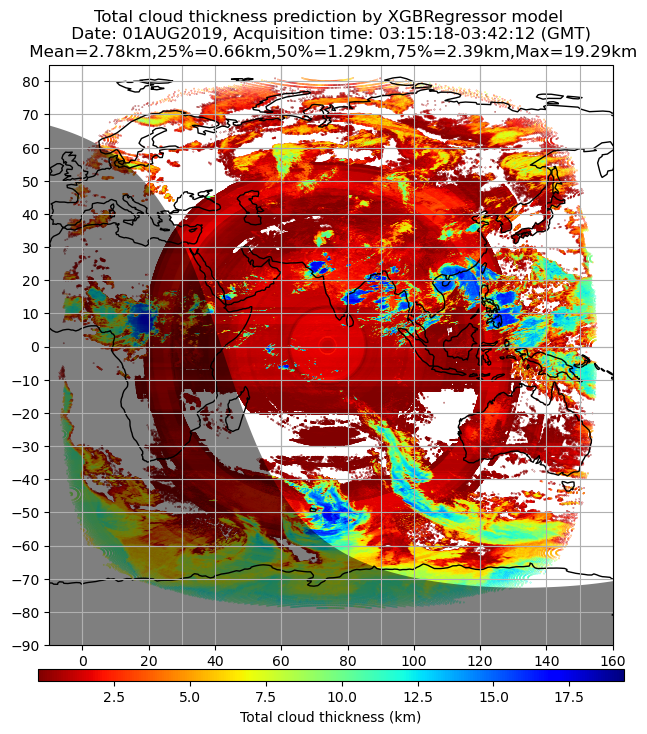

In [33]:
cloudthicknessplotter(insatfilepath = r'/data/debasish/insatdata/l1b/2019/aug2019_day1_std/3RIMG_01AUG2019_0315_L1B_STD_V01R00.h5')


01DEC2019
0315
03:15:34
03:42:28


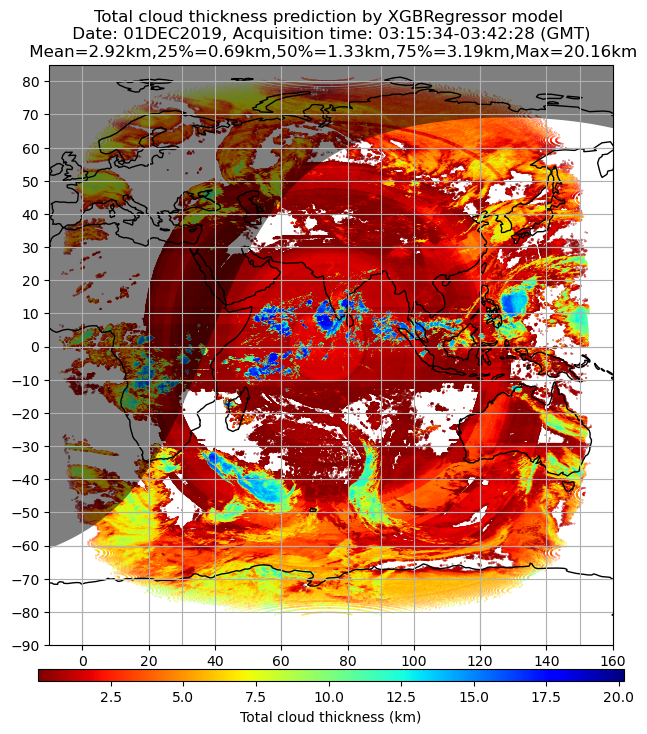

In [34]:
cloudthicknessplotter(insatfilepath = r'/data/debasish/insatdata/l1b/2019/dec2019_day1_std/3RIMG_01DEC2019_0315_L1B_STD_V01R00.h5')
